In [21]:
import os
import sys

import matplotlib.pyplot as plt
import seaborn as  sns
import pandas as pd
import numpy as np
from sklearnex import patch_sklearn

patch_sklearn()

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score, confusion_matrix)
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import xgboost as xgb

sys.path.insert(0, "\\".join(os.path.abspath(os.curdir).split("\\")[:-2:]))

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Detecção câncer de mama

### Importação

In [22]:
SELECTED_DATABASE = "mias"

try:
    breast_cancer_df = pd.read_csv(
        f"../../outputs/mamografia/{SELECTED_DATABASE}/first_order_features_{SELECTED_DATABASE}.csv"
    )
    aux = pd.read_csv(f"../../outputs/mamografia/{SELECTED_DATABASE}/glcm_features_{SELECTED_DATABASE}.csv")
    breast_cancer_df = pd.concat([breast_cancer_df.drop(columns=['pathology', 'image_path']), aux], axis=1)
except FileNotFoundError:
    raise Exception("Database not found!")

features = ['mean', 'std', 'smoothness', 'uniformity',
       'dissimilarity_dist_1_ang_135', 'correlation_dist_1_ang_0',
       'correlation_dist_1_ang_45', 'correlation_dist_1_ang_90',
       'homogeneity_dist_1_ang_0', 'contrast_dist_1_ang_0',
       'energy_dist_1_ang_0', 'ASM_dist_1_ang_0', 'ASM_dist_1_ang_45',
       'ASM_dist_1_ang_90', 'ASM_dist_1_ang_135']

breast_cancer_df = breast_cancer_df[features + ['pathology', 'image_path']]
breast_cancer_df.head()

,mean,std,smoothness,uniformity,dissimilarity_dist_1_ang_135,correlation_dist_1_ang_0,correlation_dist_1_ang_45,correlation_dist_1_ang_90,homogeneity_dist_1_ang_0,contrast_dist_1_ang_0,energy_dist_1_ang_0,ASM_dist_1_ang_0,ASM_dist_1_ang_45,ASM_dist_1_ang_90,ASM_dist_1_ang_135,pathology,image_path
0,53.165596,70.946720,0.999801,0.198968,1.017771,0.998898,0.998621,0.999728,0.775117,11.098711,0.440639,0.194163,0.193768,0.196504,0.193684,benign,D:/mathe/Documents/banco_dados_ic/mamografia/m...
1,142.088010,80.487860,0.999846,0.011862,1.950162,0.999490,0.998929,0.999424,0.550244,6.587286,0.077866,0.006063,0.005505,0.006357,0.005644,benign,D:/mathe/Documents/banco_dados_ic/mamografia/m...
2,145.798920,19.070507,0.997258,0.014897,2.200961,0.988675,0.966953,0.984596,0.442471,8.211725,0.044591,0.001988,0.001122,0.001769,0.001766,benign,D:/mathe/Documents/banco_dados_ic/mamografia/m...
3,145.798920,19.070507,0.997258,0.014897,2.200961,0.988675,0.966953,0.984596,0.442471,8.211725,0.044591,0.001988,0.001122,0.001769,0.001766,benign,D:/mathe/Documents/banco_dados_ic/mamografia/m...
4,186.046080,14.392229,0.995195,0.022627,2.540528,0.986699,0.975054,0.980780,0.506651,5.518043,0.063354,0.004014,0.002769,0.003479,0.002390,benign,D:/mathe/Documents/banco_dados_ic/mamografia/m...


### Pré-Processamento

In [23]:
# Elimina os dados com classe BENIGN_WITHOUT_CALLBACK ou NORMAL
breast_cancer_df = breast_cancer_df[breast_cancer_df["pathology"] != "benign_without_callback"]
breast_cancer_df = breast_cancer_df[breast_cancer_df["pathology"] != "normal"]

# Elimina os dados com valores nulos
breast_cancer_df.dropna(inplace=True)

# Separa em features e labels
X, y = (breast_cancer_df.drop(["pathology", "image_path"], axis=1), breast_cancer_df["pathology"])

# Tratamos os rótulos categóricos
y = y.map({"benign": 0, "malignant": 1})

# Separa os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# Balanceamento dos dados
if SELECTED_DATABASE in ["inbreast", "mias"]:
    smote = SMOTE()
    X_train, y_train = smote.fit_resample(X_train, y_train)
elif SELECTED_DATABASE in ["cmmd"]:
    random_under_sampler = RandomUnderSampler()
    X_train, y_train = random_under_sampler.fit_resample(X_train, y_train)

# Reduz a dimensionalidade
""" pca = PCA(n_components=5, random_state=42)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

print("PCA explained variance ratio: ", pca.explained_variance_ratio_)
print("PCA explained variance ratio sum: ", pca.explained_variance_ratio_.sum()) """

# Padroniza os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Treinamento dos modelos

In [24]:
""" def create_mlp_model(shape):
    model = Sequential()
    model.add(layers.Dense(24, input_dim=shape, kernel_regularizer=regularizers.L1(0.001)))
    model.add(layers.Activation("relu"))
    model.add(layers.Dropout(0.3))

    #model.add(layers.Dense(24))
    #model.add(layers.Activation("relu"))
    #model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1))
    model.add(layers.Activation("sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0005), metrics=["accuracy"])
    return model """

' def create_mlp_model(shape):\n    model = Sequential()\n    model.add(layers.Dense(24, input_dim=shape, kernel_regularizer=regularizers.L1(0.001)))\n    model.add(layers.Activation("relu"))\n    model.add(layers.Dropout(0.3))\n\n    #model.add(layers.Dense(24))\n    #model.add(layers.Activation("relu"))\n    #model.add(layers.Dropout(0.3))\n\n    model.add(layers.Dense(1))\n    model.add(layers.Activation("sigmoid"))\n    model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0005), metrics=["accuracy"])\n    return model '

In [25]:
""" kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = {"Random Forest": [], "KNN": [], "XGBoost": []}
train_scores = {"Random Forest": [], "KNN": [], "XGBoost": []}

for train_index, valid_index in kf.split(X_train):
    X_train_cv, X_valid_cv = X_train[train_index], X_train[valid_index]
    y_train_cv, y_valid_cv = y_train[train_index], y_train[valid_index]

    random_forest_model = RandomForestClassifier(bootstrap=True, class_weight='balanced',
                                                criterion='entropy', max_depth=8,
                                                max_features='sqrt', n_estimators=70,
                                                min_samples_split=3, min_samples_leaf=2,
                                                n_jobs=-1)

    xgb_model = xgb.XGBClassifier(n_estimators=25, max_depth=3, learning_rate=0.01,
                                  subsample=1.0, colsample_bytree=1.0, reg_alpha=0.5,
                                  reg_lambda=0.5, eval_metric='logloss')

    knn_model = KNeighborsClassifier(algorithm='auto', leaf_size=10, n_neighbors=15, p=1, weights='distance')

    models_names = ["Random Forest", "KNN", "XGBoost"]
    models = [random_forest_model, knn_model, xgb_model]

    for model, name in zip(models, models_names):
        model.fit(X_train_cv, y_train_cv)
        y_valid_pred = model.predict(X_valid_cv)
        y_train_pred = model.predict(X_train_cv)

        train_accuracy = accuracy_score(y_train_cv, y_train_pred)
        valid_accuracy = accuracy_score(y_valid_cv, y_valid_pred)

        scores[name].append(valid_accuracy)
        train_scores[name].append(train_accuracy)

for name in models_names:
    print(f"Train {name}: {sum(train_scores[name])/len(train_scores[name])}")
    print(f"Valid {name}: {sum(scores[name])/len(scores[name])}\n") """

' kf = KFold(n_splits=5, shuffle=True, random_state=42)\nscores = {"Random Forest": [], "KNN": [], "XGBoost": []}\ntrain_scores = {"Random Forest": [], "KNN": [], "XGBoost": []}\n\nfor train_index, valid_index in kf.split(X_train):\n    X_train_cv, X_valid_cv = X_train[train_index], X_train[valid_index]\n    y_train_cv, y_valid_cv = y_train[train_index], y_train[valid_index]\n\n    random_forest_model = RandomForestClassifier(bootstrap=True, class_weight=\'balanced\',\n                                                criterion=\'entropy\', max_depth=8,\n                                                max_features=\'sqrt\', n_estimators=70,\n                                                min_samples_split=3, min_samples_leaf=2,\n                                                n_jobs=-1)\n\n    xgb_model = xgb.XGBClassifier(n_estimators=25, max_depth=3, learning_rate=0.01,\n                                  subsample=1.0, colsample_bytree=1.0, reg_alpha=0.5,\n                            

In [26]:
# Models
random_forest_model = RandomForestClassifier(bootstrap=True, class_weight='balanced',
                                                criterion='entropy', max_depth=8,
                                                max_features='sqrt', n_estimators=70,
                                                min_samples_split=3, min_samples_leaf=2,
                                                n_jobs=-1)

knn_model = KNeighborsClassifier(algorithm='auto', leaf_size=10, n_neighbors=15, p=1, weights='distance')

xgb_model = xgb.XGBClassifier(n_estimators=25, max_depth=3, learning_rate=0.01,
                                  subsample=1.0, colsample_bytree=1.0, reg_alpha=0.5,
                                  reg_lambda=0.5, eval_metric='logloss')

titles = ["Random Forest", "KNN", "XGBoost"]
models = [random_forest_model, knn_model, xgb_model]
scores = {}
predicts = {"Random Forest": None, "KNN": None, "XGBoost": None}

for model, title in zip(models, titles):
    model.fit(X_train, y_train)
    predict = model.predict(X_test)
    predicts[title] = predict

    scores[title] = {"accuracy_score": accuracy_score(y_test, predict) * 100}
    scores[title]["precision_score"] = precision_score(y_test, predict) * 100
    scores[title]["recall_score"] = recall_score(y_test, predict) * 100
    scores[title]["f1_score"] = f1_score(y_test, predict) * 100

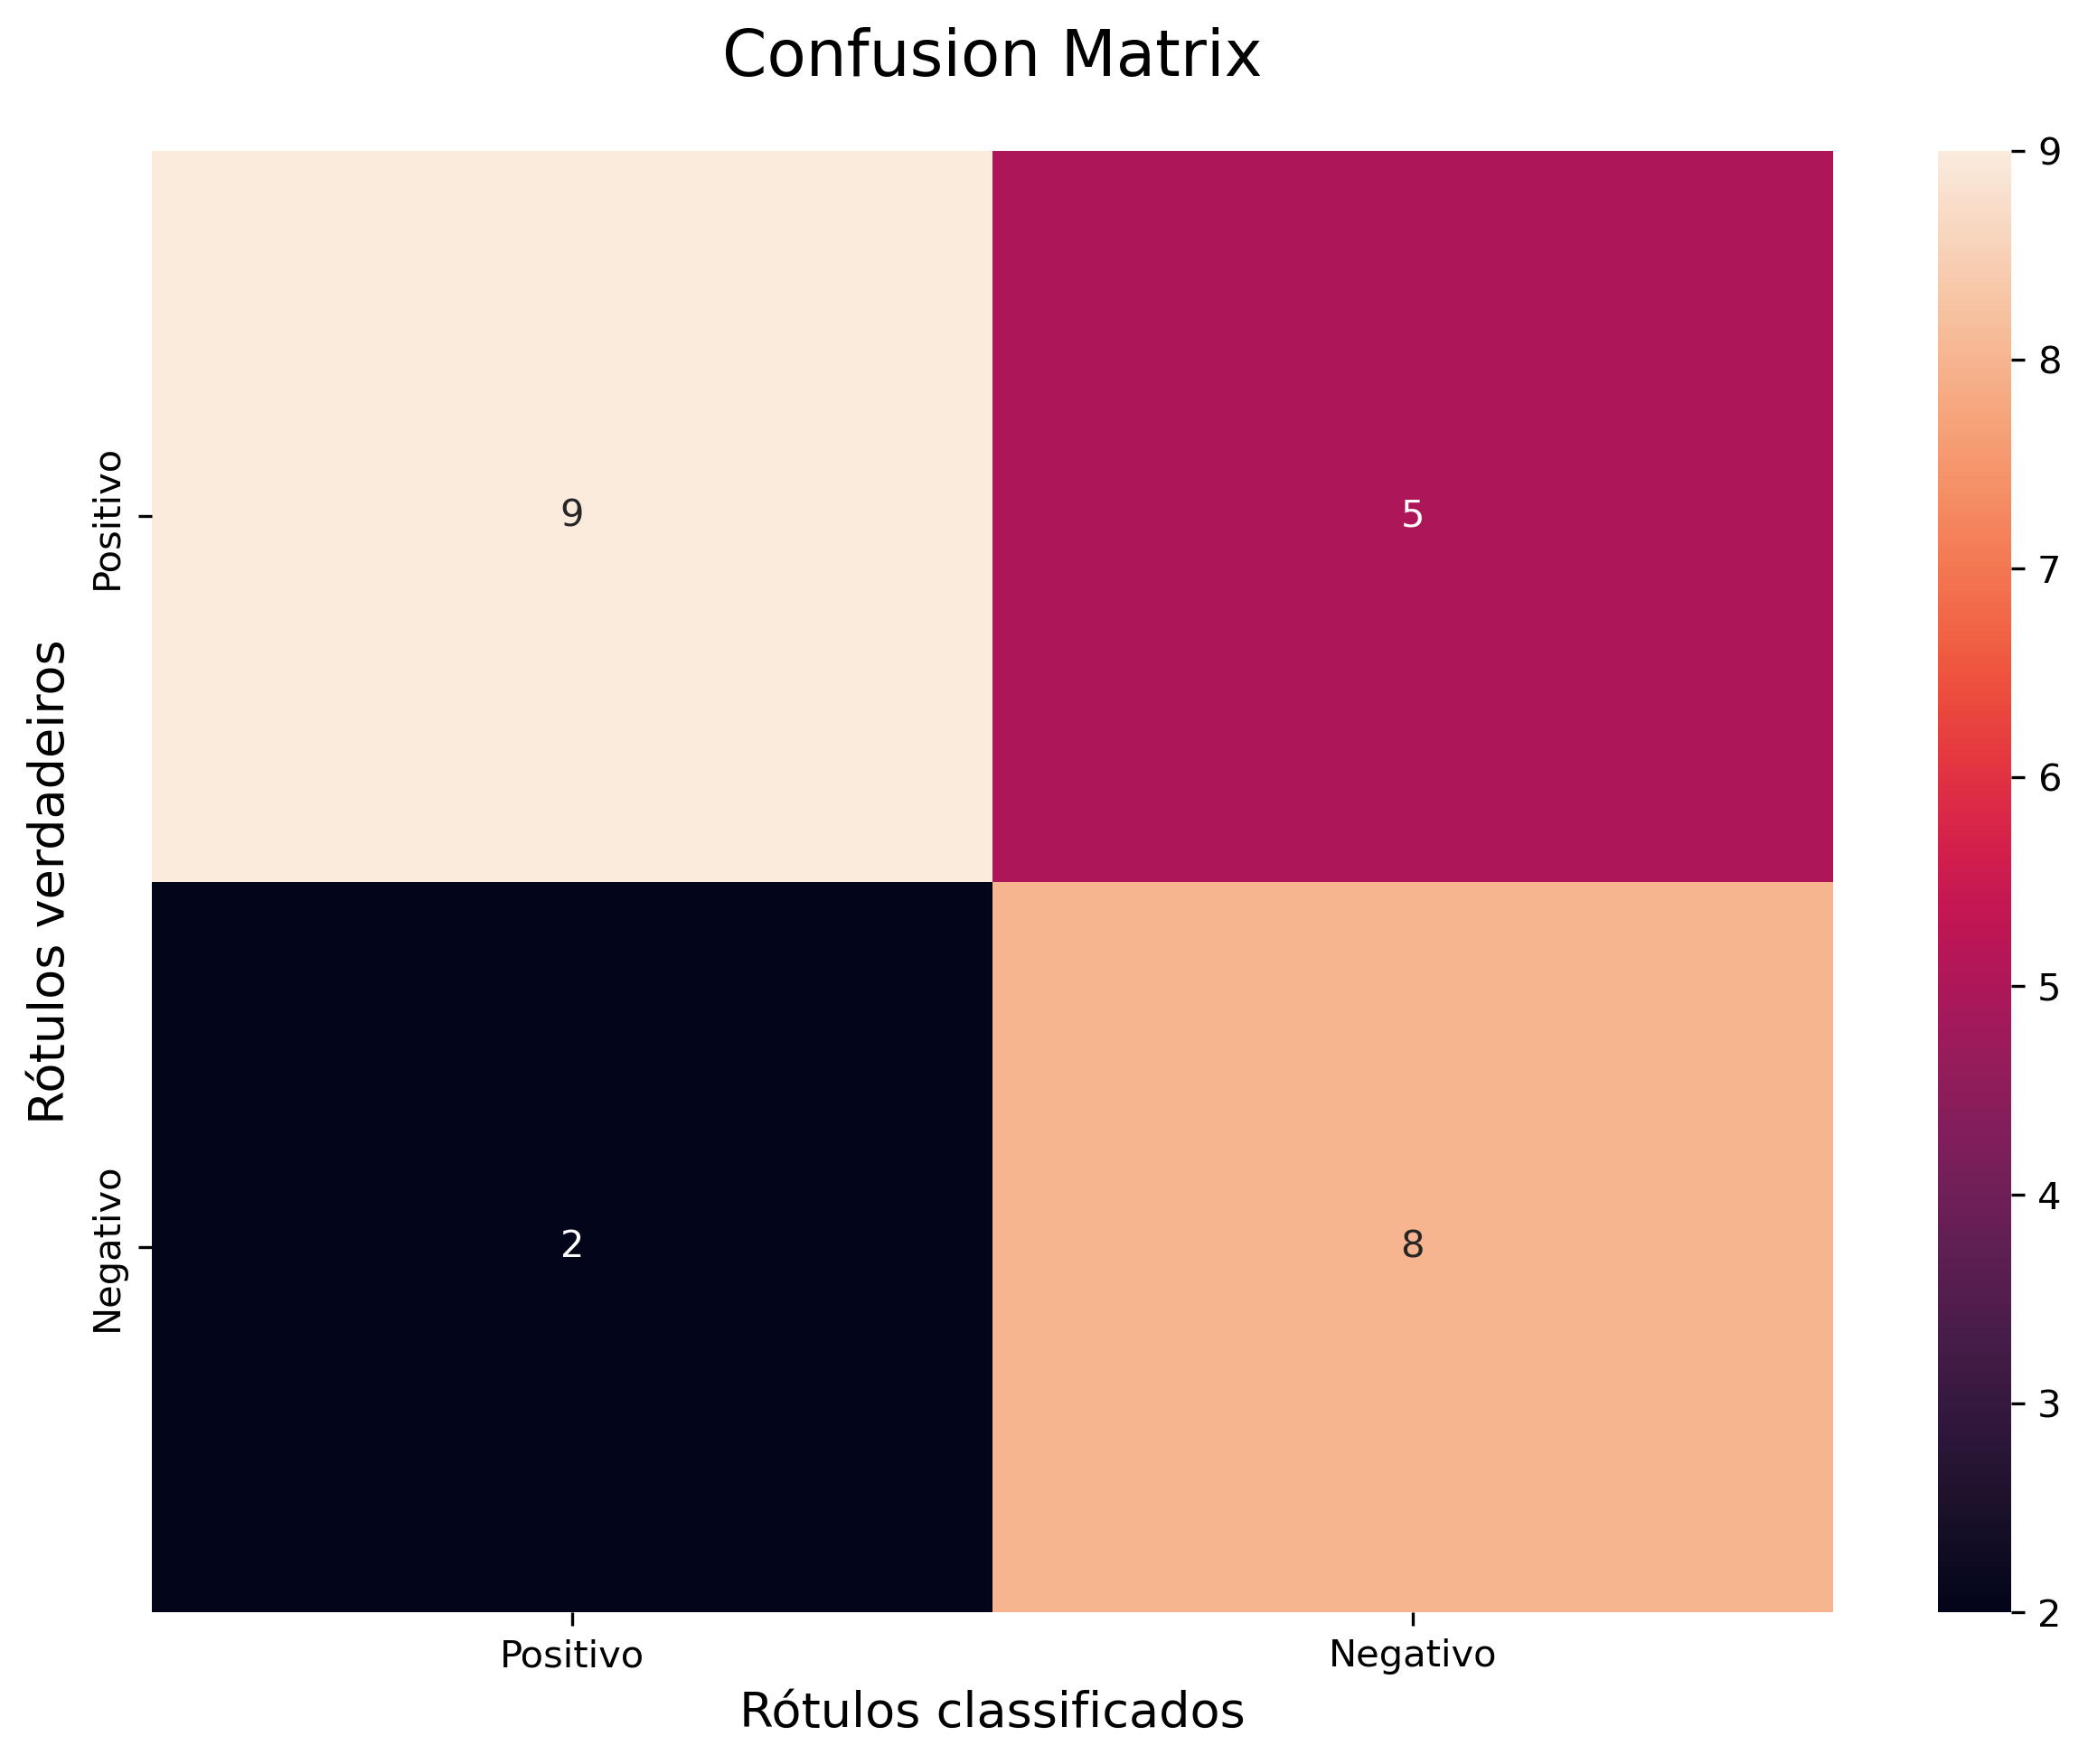

In [34]:
cm = confusion_matrix(y_test, predicts['XGBoost'])

# Visualiza a matriz de confusão com seaborn
fig, ax = plt.subplots(figsize=(10, 7), dpi=300)
sns.heatmap(cm,
            ax=ax,
            annot=True,
            fmt='g',
            xticklabels=['Positivo','Negativo'],
            yticklabels=['Positivo','Negativo'])
plt.ylabel('Rótulos verdadeiros', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('bottom')
plt.xlabel('Rótulos classificados', fontsize=13)
plt.gca().xaxis.tick_bottom()

#plt.gca().figure.subplots_adjust(bottom=0.2)
#plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
plt.show()

### Avaliação dos modelos

In [28]:
scores_df = pd.DataFrame(scores).T
scores_df

,accuracy_score,precision_score,recall_score,f1_score
Random Forest,62.500000,53.846154,70.0,60.869565
KNN,62.500000,53.333333,80.0,64.000000
XGBoost,70.833333,61.538462,80.0,69.565217


In [29]:
result = [[62.5, 50.0, 75], [66.66, 50.0, 66.66], [66.66, 66.66, 70.83], [66.66, 75, 66.66],
          [75, 75, 70.83], [62.50, 66.66, 70.83], [62.50, 58.33, 62.50]]
columns=['Random Forest', 'KNN', 'XGBoost']
df = pd.DataFrame(result, columns=columns)

def mean_without_extremes(df):
    new_df = pd.DataFrame(columns=df.columns)
    for col in df.columns:
        df.sort_values(by=col, inplace=True)
        df[col] = df[col].drop(df[col].index[[0, -1]])
        new_df[col] = [df[col].mean()]
    return new_df

df = mean_without_extremes(df)
df

,Random Forest,KNN,XGBoost
0,64.996,63.33,69.162


In [30]:
""" import cv2

predict = predicts["XGBoost"]
image_paths = breast_cancer_df.loc[y_test.index, "image_path"]

true_positive = []
true_negative = []
false_positive = []
false_negative = []

for i in range(len(y_test)):
    if y_test.iloc[i] == 1 and predict[i] == 1:
        true_positive.append(image_paths.iloc[i])
    elif y_test.iloc[i] == 0 and predict[i] == 0:
        true_negative.append(image_paths.iloc[i])
    elif y_test.iloc[i] == 0 and predict[i] == 1:
        false_positive.append(image_paths.iloc[i])
    elif y_test.iloc[i] == 1 and predict[i] == 0:
        false_negative.append(image_paths.iloc[i])

image_true_positive = cv2.imread(true_positive[2], cv2.IMREAD_GRAYSCALE)
image_false_positive = cv2.imread(false_positive[0], cv2.IMREAD_GRAYSCALE)
image_true_negative = cv2.imread(true_negative[0], cv2.IMREAD_GRAYSCALE)
image_false_negative = cv2.imread(false_negative[0], cv2.IMREAD_GRAYSCALE)

ys = [0, 1, 0, 1]
xs = [0, 0, 1, 1]
titles = ["Verdadeiro positivo", "Falso Positivo", "Verdadeiro Negativo", "Falso Negativo"]
images = [image_true_positive, image_false_positive, image_true_negative, image_false_negative]
fig, axs = plt.subplots(2, 2, figsize=(6, 6), dpi=300)

for i, ax in enumerate(axs.flat):
    enhanced_image = cv2.medianBlur(images[i], 3)
    enhanced_image = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(6, 6)).apply(enhanced_image)
    ax.imshow(enhanced_image, cmap="gray")
    ax.set_title(titles[i])
    ax.axis("off")

plt.tight_layout()
plt.show() """

' import cv2\n\npredict = predicts["XGBoost"]\nimage_paths = breast_cancer_df.loc[y_test.index, "image_path"]\n\ntrue_positive = []\ntrue_negative = []\nfalse_positive = []\nfalse_negative = []\n\nfor i in range(len(y_test)):\n    if y_test.iloc[i] == 1 and predict[i] == 1:\n        true_positive.append(image_paths.iloc[i])\n    elif y_test.iloc[i] == 0 and predict[i] == 0:\n        true_negative.append(image_paths.iloc[i])\n    elif y_test.iloc[i] == 0 and predict[i] == 1:\n        false_positive.append(image_paths.iloc[i])\n    elif y_test.iloc[i] == 1 and predict[i] == 0:\n        false_negative.append(image_paths.iloc[i])\n\nimage_true_positive = cv2.imread(true_positive[2], cv2.IMREAD_GRAYSCALE)\nimage_false_positive = cv2.imread(false_positive[0], cv2.IMREAD_GRAYSCALE)\nimage_true_negative = cv2.imread(true_negative[0], cv2.IMREAD_GRAYSCALE)\nimage_false_negative = cv2.imread(false_negative[0], cv2.IMREAD_GRAYSCALE)\n\nys = [0, 1, 0, 1]\nxs = [0, 0, 1, 1]\ntitles = ["Verdadeiro p